# Hurricane Damage Detector

Hurricane is one of the most disastrous natural disasters causing immense harm to the ecosystem and economic system worldwide. It is also known as a tropical cyclone. Heavy rainfall and high winds accompanying hurricane inflict damage to property as well as loss of human life. Hence, appropriate steps need to be taken to mitigate the damage caused by the disaster. 

Satellite imagery is being used for damage detection due to its ability to cover large spatial and temporal areas. But manual damage detection is error prone. Therefore, machine learning and deep learning which automated methods are used for detection of damage. This analysis includes the use of machine learning and deep learning for detection of damage caused by natural disasters with a special focus on hurricane damage.

The original paper that worked on this problem: https://arxiv.org/abs/1807.01688

To view the full datasets:
https://ieee-dataport.org/open-access/detecting-damaged-buildings-post-hurricane-satellite-imagery-based-customized 

## Get and Load Dataset

A version of the data is being stored in google drive

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown --id 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:00<00:00, 218MB/s]


In [ ]:
!unzip -q hurricane_detector.zip

replace train_hurricane/no_damage/-95.638504_29.838933.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
ls -l

total 38748
-rw-r--r-- 1 root root 39662128 Jun 24 12:41 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 Jun 15 13:42 sample_data/
drwxr-xr-x 4 root root     4096 Jun 24 11:20 test_hurricane/
drwxr-xr-x 4 root root     4096 Jun 24 11:20 train_hurricane/


In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage [655 entries exceeds filelimit, not opening dir]
└── no_damage [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [ ]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage [5895 entries exceeds filelimit, not opening dir]
└── no_damage [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Load Dependencies

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.8.2


## Utility functions to create dataset generators

In [ ]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions


In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


**Seeing a samples of the pictures**

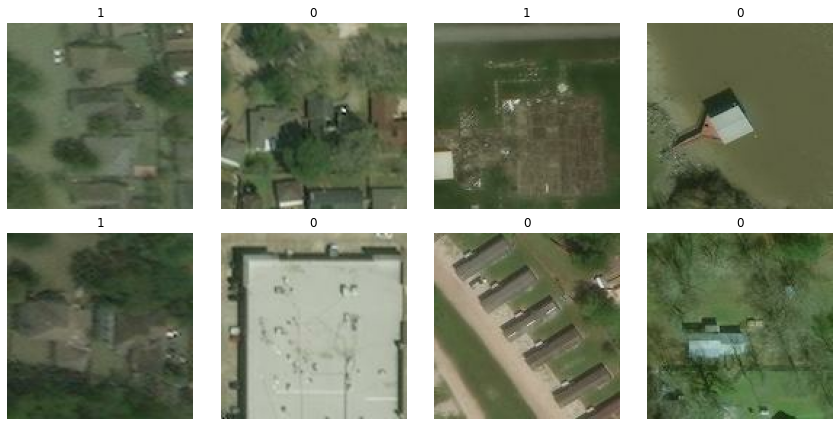

In [ ]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

# Plans and Questions to investigate:


- How much data/pictures we have in both train, validation and test?

- Do we have an imbalance classes? Do we need to handle this issue?

- Enhance the quality of the pictures

- Build base model

- Use pre-trained model, ResNet50

- Fine tune the pretrained model to enhance the results (if needed)






In [ ]:
img_paths=[]
img_labels=[]
for i in glob('/content/train_hurricane/**',recursive=True):
    if i.endswith('.jpeg'):
        a=i.split('/')
        img_paths.append(i)
        img_labels.append(a[-2])
len(img_paths),len(img_labels)

(1358, 1358)

In [ ]:
img_paths2=[]
img_labels2=[]
for i in glob('/content/test_hurricane/**',recursive=True):
    if i.endswith('.jpeg'):
        a=i.split('/')
        img_paths2.append(i)
        img_labels2.append(a[-2])
len(img_paths2),len(img_labels2)


img_path2 = pd.Series(img_paths2).astype(str)
labels2=pd.Series(img_labels2)
data_test = pd.concat([img_path2,labels2],axis=1)
data_test.columns = ['path','classes']

img_path = pd.Series(img_paths).astype(str)
labels=pd.Series(img_labels)
data = pd.concat([img_path,labels],axis=1)
data.columns = ['path','classes']

no_damage    703
damage       655
Name: classes, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


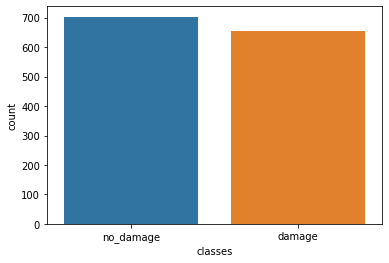

In [ ]:
display(data.classes.value_counts())
print('='*100)
sns.countplot(data.classes,data=data);

**It seems we have relatively balanced classes in training datasets - no classweights handling will be used**

**However since we have small datasets and the quality looks bad, we are going to use data augmentaiton and enhance contrast**

no_damage    6333
damage       5895
Name: classes, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


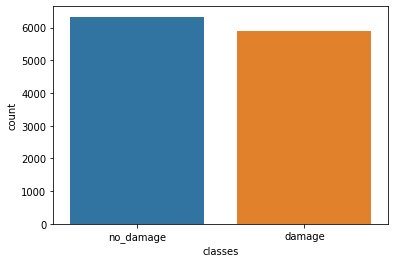

In [ ]:
display(data_test.classes.value_counts())
print('='*100)
sns.countplot(data_test.classes,data=data_test);

In [ ]:
#!ls train_hurricane/damage | wc -l
#!ls train_hurricane/no_damage | wc -l

## Picture Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


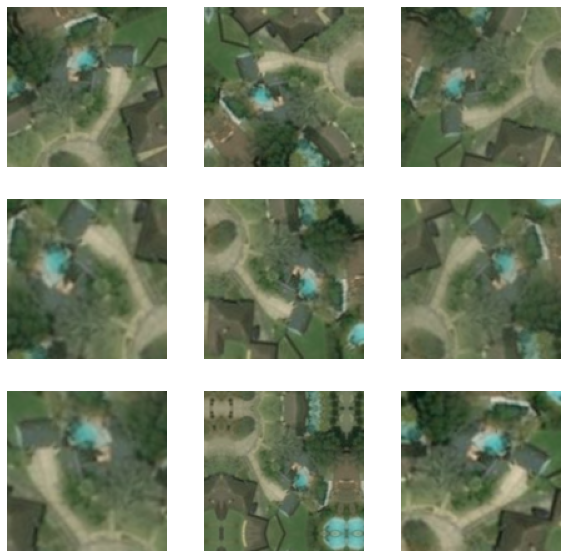

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
  tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),
])


# visualizing the result of augmentation on one image
for image, labels in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
print('Imaged shape and dimensions:')

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Imaged shape and dimensions:
(32, 128, 128, 3)
(32,)


# Base Model

We are going to build a convolution neural netwrok from scratch. The idea is to see how much will we get from it and use it as a threshold to compare our pre-trained choice (before and after tuning) 

In [ ]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')])

model.build(input_shape=((None, 128, 128, 3)))

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  epochs=epochs,
  validation_data=val_ds)

Epoch 1/15
34/34 [==============================] - 17s 439ms/step - loss: 0.6924 - accuracy: 0.5409 - val_loss: 0.5803 - val_accuracy: 0.7823
Epoch 2/15
34/34 [==============================] - 13s 365ms/step - loss: 0.5794 - accuracy: 0.6992 - val_loss: 0.5790 - val_accuracy: 0.7528
Epoch 3/15
34/34 [==============================] - 13s 370ms/step - loss: 0.5510 - accuracy: 0.7130 - val_loss: 0.5843 - val_accuracy: 0.6900
Epoch 4/15
34/34 [==============================] - 13s 372ms/step - loss: 0.5662 - accuracy: 0.7093 - val_loss: 0.5051 - val_accuracy: 0.7749
Epoch 5/15
34/34 [==============================] - 13s 371ms/step - loss: 0.5415 - accuracy: 0.7305 - val_loss: 0.5564 - val_accuracy: 0.7343
Epoch 6/15
34/34 [==============================] - 13s 369ms/step - loss: 0.4949 - accuracy: 0.7663 - val_loss: 0.4191 - val_accuracy: 0.8524
Epoch 7/15
34/34 [==============================] - 13s 388ms/step - loss: 0.4871 - accuracy: 0.7783 - val_loss: 0.3989 - val_accuracy: 0.8487

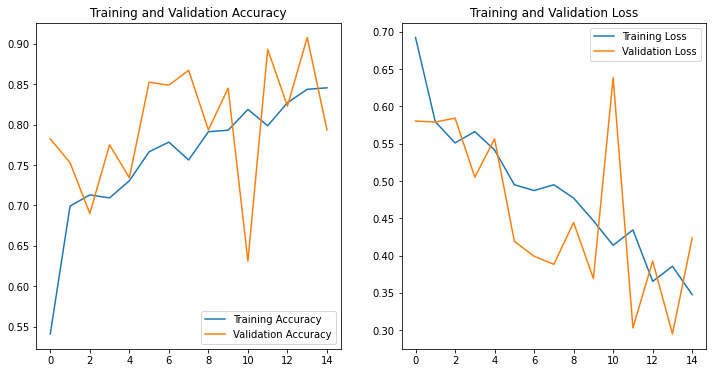

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Around 80% (give or take). A lot of fluctuation in the error though, most probably due to small datasets.

Before using ResNet. I am going to use VGG16 as another base model. We will not tune it however rather use it benchmark for pre-trained models.

# Using VGG model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
IMAGE_SIZE=[128,128]

vgg = VGG16(input_shape= IMAGE_SIZE + [3],weights='imagenet',include_top=False)

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

**Without tunning, i.e. using the model structure/weights as is**

In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
for layer in vgg.layers[-5:]:
  print(layer.name)

block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = vgg(image_batch)
print(feature_batch.shape)

(32, 4, 4, 512)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
model_non_tunned = tf.keras.Sequential([vgg,
                             global_average_layer,
                             prediction_layer])

In [ ]:
base_learning_rate = 0.0001
model_non_tunned.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_non_tunned.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history2 = model_non_tunned.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
34/34 [==============================] - 117s 3s/step - loss: 2.3710 - accuracy: 0.4618 - val_loss: 2.0648 - val_accuracy: 0.4871
Epoch 2/10
34/34 [==============================] - 114s 3s/step - loss: 1.9252 - accuracy: 0.4775 - val_loss: 1.7748 - val_accuracy: 0.5129
Epoch 3/10
34/34 [==============================] - 113s 3s/step - loss: 1.6958 - accuracy: 0.5189 - val_loss: 1.5997 - val_accuracy: 0.5277
Epoch 4/10
34/34 [==============================] - 114s 3s/step - loss: 1.5314 - accuracy: 0.5575 - val_loss: 1.4697 - val_accuracy: 0.5535
Epoch 5/10
34/34 [==============================] - 113s 3s/step - loss: 1.4021 - accuracy: 0.5851 - val_loss: 1.3549 - val_accuracy: 0.5941
Epoch 6/10
34/34 [==============================] - 112s 3s/step - loss: 1.2895 - accuracy: 0.6063 - val_loss: 1.2586 - val_accuracy: 0.6199
Epoch 7/10
34/34 [==============================] - 112s 3s/step - loss: 1.1914 - accuracy: 0.6274 - val_loss: 1.1739 - val_accuracy: 0.6458
Epoch 8/10
34

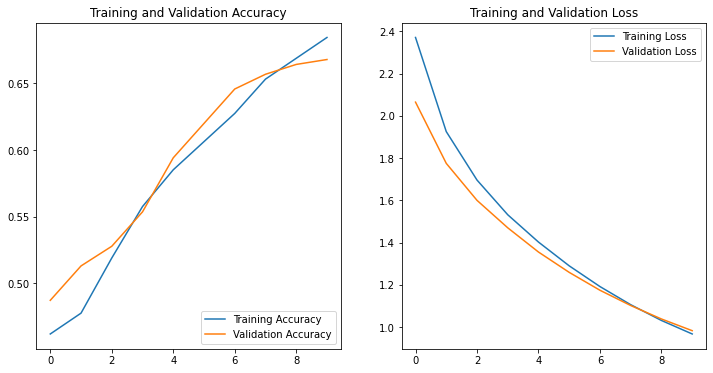

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Although we received much less than our 80% accurancy, still the curve seems more stable and promising**. 

Remeber: 
- We trained the model only for 10 epochs 
- We didn't use preprocessing when merging the model with our prediction layers

## ResNet50

We will:
- Directly fine tune the model by training all layers after layer 100 (arbitrary number of choice)
- Use preprocessing layers
- Ensure to use our augmented preprocessing

In [ ]:
model_name = 'resnet50_v01'

# load a new instance of the model.
model_res = tf.keras.applications.resnet50.ResNet50(input_shape=(128,128,3),
                                              include_top=False,
                                              weights='imagenet')

model_res.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [ ]:
model_res.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model_res.layers))

Number of layers in the base model:  175


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_res.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = model_res(x, training=False)  # important: training=False
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                           

In [ ]:
initial_epochs = 15

history3 = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/15
34/34 [==============================] - 106s 3s/step - loss: 0.5148 - accuracy: 0.7590 - val_loss: 0.3560 - val_accuracy: 0.8266
Epoch 2/15
34/34 [==============================] - 98s 3s/step - loss: 0.3258 - accuracy: 0.8629 - val_loss: 0.2975 - val_accuracy: 0.8635
Epoch 3/15
34/34 [==============================] - 102s 3s/step - loss: 0.2496 - accuracy: 0.8868 - val_loss: 0.2423 - val_accuracy: 0.9004
Epoch 4/15
34/34 [==============================] - 104s 3s/step - loss: 0.2027 - accuracy: 0.9227 - val_loss: 0.2048 - val_accuracy: 0.9114
Epoch 5/15
34/34 [==============================] - 107s 3s/step - loss: 0.1832 - accuracy: 0.9200 - val_loss: 0.2016 - val_accuracy: 0.9114
Epoch 6/15
34/34 [==============================] - 99s 3s/step - loss: 0.1696 - accuracy: 0.9292 - val_loss: 0.2699 - val_accuracy: 0.8967
Epoch 7/15
34/34 [==============================] - 98s 3s/step - loss: 0.1575 - accuracy: 0.9420 - val_loss: 0.1638 - val_accuracy: 0.9446
Epoch 8/15
34/34

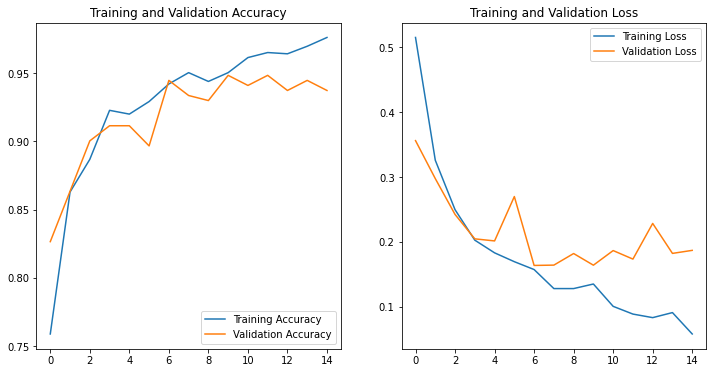

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Not bad for a starter. 93.73% validation accuracy with somehow smooth error curve.

Next plan is:


*   Train for more epochs (here we used 15 for lack of times)
*   Test using Keras_tuner for hyperparameter tunning
  *   Testing different optimizers
  *   Vary learning rate
